# Import

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, LSTM
from tensorflow.keras.optimizers import Adam

#import keras_tuner as kt

from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

checkpoint_dir = '/content/drive/MyDrive/maga/checkpoints/classification/3'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [3]:
def print_metrics(y_test, y_pred, X_train, csv_name):
  test_results = {}
  test_results['accuracy'] = accuracy_score(y_test, y_pred)
  test_results['precision'] = precision_score(y_test, y_pred, average='macro')
  test_results['recall'] = recall_score(y_test, y_pred, average='macro')
  test_results['f1'] = f1_score(y_test, y_pred, average='macro')
  print(test_results)
  if csv_name != None:
    metrics_df = pd.DataFrame(test_results, index=['metrics']).T
    metrics_df.to_csv('/content/drive/MyDrive/maga/metrics/' + csv_name + '.csv')


def acc_loss_plot(history, plot_name):
  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(8, 5))
  ax = sns.lineplot(data=history['acc'], label='Train acc', color='lightblue')
  ax = sns.lineplot(data=history['val_acc'], label='Valid acc', color='steelblue')
  ax.set_xlim(0, len(history)-1)
  ax.set_title('График значения метрики accuracy\nдля тренировочной и валидационной выборки', fontsize=12, fontweight='bold')
  ax.set_xlabel('Номер эпохи', fontsize=12)
  ax.set_ylabel('Значение метрики accuracy', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/mae_plot/acc_plot_' + plot_name + '.png')

  sns.set_style("whitegrid")
  fig, ax1 = plt.subplots(figsize=(8, 5))
  ax1 = sns.lineplot(data=history['loss'], label='Train loss', color='lightblue')
  ax1 = sns.lineplot(data=history['val_loss'], label='Valid loss', color='steelblue')
  ax1.set_xlim(0, len(history)-1)
  ax1.set_title('График значения функции потерь\nдля тренировочной и валидационной выборки', fontsize=12, fontweight='bold')
  ax1.set_xlabel('Номер эпохи', fontsize=12)
  ax1.set_ylabel('Значение функции потерь', fontsize=12)
  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/mae_plot/loss_plot_' + plot_name + '.png')


def confusion_matrix_plot(y_test, y_pred, plot_name):
  cf_matrix = confusion_matrix(y_test, y_pred)

  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(3,3)

  fig, ax = plt.subplots(figsize=(5, 4))
  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"fontsize":12})
  ax.set_title('Матрица ошибок', fontsize=12, fontweight='bold')
  ax.set_xlabel('Предсказанные значения', fontsize=12)
  ax.set_ylabel('Истинные значения', fontsize=12)
  ax.xaxis.set_ticklabels(['Простейший', 'MMPP', 'Рекуррентный'], fontsize=12)
  ax.yaxis.set_ticklabels(['Простейший', 'MMPP', 'Рекуррентный'], fontsize=12)

  if plot_name != None:
    fig.savefig('/content/drive/MyDrive/maga/pic/conf_matrix/conf_matr_' + plot_name + '.png')


def save_load_history(history, history_dir, save_flag):
  if save_flag:
    hist_df = pd.DataFrame(history.history)
    with open(history_dir, mode='w') as f:
      hist_df.to_csv(f)
  else:
    hist_df = pd.read_csv(history_dir, sep=',', engine='python', index_col=0)
    return hist_df

# Read and split

In [4]:
df_pois = pd.read_csv('/content/drive/MyDrive/maga/dataset/dataset_pois.csv', sep=',', index_col=0)
df_mmpp = pd.read_csv('/content/drive/MyDrive/maga/dataset/dataset_mmpp.csv', sep=',', index_col=0)
df_reccur = pd.read_csv('/content/drive/MyDrive/maga/dataset/dataset_reccur.csv', sep=',', index_col=0)

In [5]:
df_pois['type'] = 0 # 'pois'
df_mmpp['type'] = 1 # 'mmpp'
df_reccur['type'] = 2 # 'reccur'

In [6]:
X = df_pois.iloc[0:5000, 0:500]
X1 = df_mmpp.iloc[0:5000, 0:500]
X2 = df_reccur.iloc[0:5000, 0:500]
X = X.append(X1)
X = X.append(X2)

<ipython-input-6-bd14d536a4b6>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(X1)
<ipython-input-6-bd14d536a4b6>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(X2)


In [7]:
y = df_pois.iloc[0:5000, 1000:1002]
y1 = df_mmpp.iloc[0:5000, 1500:1612]
y2 = df_reccur.iloc[0:5000, 1000:1004]
y = y.append(y1)
y = y.append(y2)

<ipython-input-7-cd06ca60fe73>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(y1)
<ipython-input-7-cd06ca60fe73>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(y2)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, shuffle=True)

In [9]:
y_pois = y_train[y_train['type'] == 0][['lmbd_value', 'type']]
y_mmpp = y_train[y_train['type'] == 1]
y_mmpp = y_mmpp.drop(['lmbd_value', 'alpha_value', 'beta_value', 'lmbd'], axis=1)
y_reccur = y_train[y_train['type'] == 2][['alpha_value', 'beta_value', 'lmbd', 'type']]

In [10]:
q_mmpp = y_mmpp.iloc[:, 1:101]
k = y_mmpp.iloc[:, 111:112]
k = k.values.tolist()
q_mmpp = q_mmpp.values.tolist()
q_mmpp_without_zero = []
for i in range(len(q_mmpp)):
  q_mmpp_without_zero.append(list(filter(lambda num: num != 0, q_mmpp[i])))
lmbd_list_mmpp = y_mmpp.iloc[:, 101:111]
lmbd_list_mmpp = lmbd_list_mmpp.values.tolist()
lmbd_list_mmpp_without_zero = []
for i in range(len(lmbd_list_mmpp)):
  lmbd_list_mmpp_without_zero.append(list(filter(lambda num: num != 0, lmbd_list_mmpp[i])))
def calculation_pi(q_matrix_for_solve, matrix_size):
    v = np.zeros(matrix_size)
    v[-1] = 1
    pi = np.linalg.solve(q_matrix_for_solve, v)
    return pi

lmbd_value_mmpp = []

for s in range(len(lmbd_list_mmpp_without_zero)):
  l=0
  res=[]
  for i in range(0, int(k[s][0])):
    sub = []
    for j in range(0, int(k[s][0])):
        sub.append(q_mmpp_without_zero[s][l])
        l += 1
    res.append(sub)

  q_matrix = np.matrix(res)
  q_matrix[int(k[s][0])-1] = np.ones(int(k[s][0]))
  r = calculation_pi(q_matrix, int(k[s][0]))
  r = r.reshape(1,-1)
  e = np.zeros(int(k[s][0]))
  e = e.reshape(1,-1)
  e[0:int(k[s][0])] = 1
  lmbd_value_mmpp.append(r.dot(np.array(lmbd_list_mmpp_without_zero[s]).reshape(int(k[s][0]),1)).dot(e)[0][0])
y_mmpp['lmbd_value_mmpp'] = lmbd_value_mmpp

In [11]:
y_mmpp = y_mmpp[y_mmpp['type'] == 1][['lmbd_value_mmpp', 'type']]
y_mmpp = y_mmpp.rename(columns={"lmbd_value_mmpp": "lmbd"})
y_pois = y_pois.rename(columns={"lmbd_value": "lmbd"})
y_reccur = y_reccur.drop(['alpha_value', 'beta_value'], axis=1)
y_reccur = y_reccur.rename(columns={"lmbd_value": "lmbd"})
y_reccur = y_reccur.append(y_pois)
y_reccur = y_reccur.append(y_mmpp)
y_reccur = y_reccur.rename(columns={"type": "Тип потока"})
y_reccur['Тип потока'] = y_reccur['Тип потока'].map({0: 'Пуассоновский', 1: 'MMPP', 2:'Рекуррентный'})

<ipython-input-11-3f56f306f3bd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_reccur = y_reccur.append(y_pois)
<ipython-input-11-3f56f306f3bd>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_reccur = y_reccur.append(y_mmpp)


In [105]:
colors = ['blue', 'red', 'green']

In [ ]:
plt.plot()

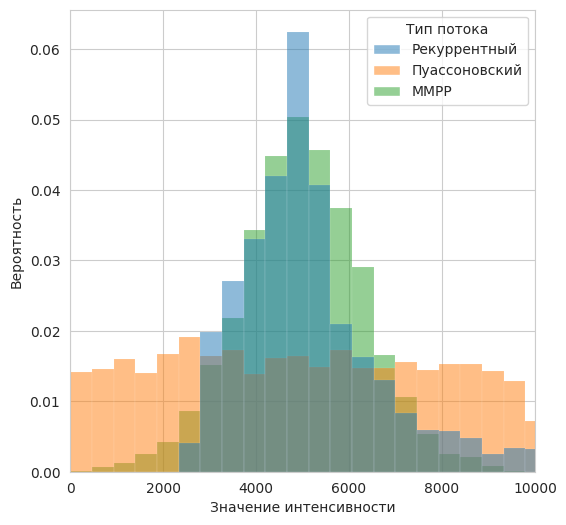

In [106]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_style('whitegrid')

sns.histplot(x=y_reccur['lmbd'], hue=y_reccur['Тип потока'], stat='probability', bins=450, color=colors)

ax.set_xlabel('Значение интенсивности')
ax.set_ylabel('Вероятность')
ax.set_xlim(0, 10000);

In [13]:
y = df_pois.iloc[0:5000, 1001:1002]
y1 = df_mmpp.iloc[0:5000, 1611:1612]
y2 = df_reccur.iloc[0:5000, 1003:1004]
y = y.append(y1)
y = y.append(y2)

<ipython-input-13-7838e9b41ae7>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(y1)
<ipython-input-13-7838e9b41ae7>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(y2)


In [14]:
num_class = len(np.unique(y.values))
num_class

3

In [92]:
lookback = 30

In [93]:
X_organized, y_organized = [], []
for i in range(0, X.shape[0]-lookback, 1):
    X_organized.append(X.values[i:i+lookback])
    y_organized.append(y.values[i+lookback])

In [94]:
X_organized, y_organized = np.array(X_organized), np.array(y_organized)
X_train, X_test, y_train, y_test = train_test_split(X_organized, y_organized, train_size=0.7, random_state=42, shuffle=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, shuffle=True)

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10500, 500), (10500, 1), (4500, 500), (4500, 1))

In [20]:
X_organized.shape, y_organized.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14970, 30, 500),
 (14970, 1),
 (10500, 500),
 (10500, 1),
 (4500, 500),
 (4500, 1))

In [21]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

1


# NN keras

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
def build_model(hp):
    dnn_layers_ss = [1,2,3,4,5]
    dnn_units_min, dnn_units_max = 32, 256
    active_func_ss = ['relu', 'sigmoid', 'selu']
    optimizer_ss = ['adam']
    lr_min, lr_max = 1e-4, 1e-1
    dropout_value = [0.1, 0.2, 0.3, 0.4]

    active_func = hp.Choice('activation', active_func_ss)
    optimizer = hp.Choice('optimizer', optimizer_ss)
    lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')
    drop = hp.Choice('rate', dropout_value)

    inputs = Input(shape=(X_train.shape[1],))

    # create hidden layers
    dnn_units = hp.Int(f"0_units", min_value=dnn_units_min, max_value=dnn_units_max)
    dense = Dense(units=dnn_units, activation=active_func)(inputs)
    for layer_i in range(hp.Choice("n_layers", dnn_layers_ss) - 1):
        dnn_units = hp.Int(f"{layer_i}_units", min_value=dnn_units_min, max_value=dnn_units_max)
        dense = Dense(units=dnn_units, activation=active_func)(dense)
        if hp.Boolean("dropout"):
          Dropout(rate=drop)(dense)
    outputs = Dense(units=num_class, activation='softmax')(dense)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics='acc')
    return model
    #, kernel_regularizer=regularizers.l2(0.001)

# Tune Bayesian

In [ ]:
!pip install -q keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.2 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_acc',
    max_trials=20,
    overwrite=False,
    directory='/content/drive/MyDrive/maga/tune',
    project_name='recur_class')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)

In [ ]:
tuner.search(
    X_train,
    to_categorical(y_train),
    epochs=5,
    validation_split=0.2,
    callbacks=[stop_early],
)

Trial 20 Complete [00h 00m 10s]
val_acc: 0.3390476107597351

Best val_acc So Far: 0.49761903285980225
Total elapsed time: 00h 03m 18s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

{'activation': 'relu',
 'optimizer': 'adam',
 'learning_rate': 0.0003121668393578294,
 'rate': 0.1,
 '0_units': 975,
 'n_layers': 4,
 'dropout': True,
 '1_units': 751,
 '2_units': 3484,
 '3_units': 2470}

In [ ]:
best_model = tuner.get_best_models()[0]

best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 114)               57114     
                                                                 
 dense_1 (Dense)             (None, 114)               13110     
                                                                 
 dense_2 (Dense)             (None, 67)                7705      
                                                                 
 dense_3 (Dense)             (None, 124)               8432      
                                                                 
 dense_4 (Dense)             (None, 32)                4000      
                                                                 
 dense_5 (Dense)             (None, 3)                 99    

In [ ]:
def myprint(s):
    with open('/content/drive/MyDrive/maga/model_summary/classification.txt','a') as f:
        print(s, file=f)

best_model.summary(print_fn=myprint)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/maga/checkpoints/recurr'
checkpoint_name = '/recurr_reg_interval_bayesian_3layers_70epochs_3000_uni_exp'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir + checkpoint_name,
                                                 monitor='val_mae',
                                                 save_weights_only=False,
                                                 verbose=1)

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, to_categorical(y_train), epochs=30, validation_split=0.2, shuffle=True)
#, callbacks=[cp_callback]

Epoch 1/30
263/263 [==============================] - 11s 13ms/step - loss: 1.1472 - acc: 0.3860 - val_loss: 1.0524 - val_acc: 0.3919
Epoch 2/30
263/263 [==============================] - 1s 5ms/step - loss: 1.0816 - acc: 0.4532 - val_loss: 0.9842 - val_acc: 0.4986
Epoch 3/30
263/263 [==============================] - 2s 7ms/step - loss: 1.0431 - acc: 0.4613 - val_loss: 1.0058 - val_acc: 0.4505
Epoch 4/30
263/263 [==============================] - 1s 5ms/step - loss: 0.9982 - acc: 0.4835 - val_loss: 1.0753 - val_acc: 0.4014
Epoch 5/30
263/263 [==============================] - 1s 5ms/step - loss: 1.0180 - acc: 0.4729 - val_loss: 0.9754 - val_acc: 0.4967
Epoch 6/30
263/263 [==============================] - 1s 5ms/step - loss: 1.0078 - acc: 0.4929 - val_loss: 0.9866 - val_acc: 0.4900
Epoch 7/30
263/263 [==============================] - 1s 5ms/step - loss: 0.9914 - acc: 0.4849 - val_loss: 1.0064 - val_acc: 0.4695
Epoch 8/30
263/263 [==============================] - 1s 5ms/step - loss: 

In [ ]:
from keras.utils.vis_utils import plot_model

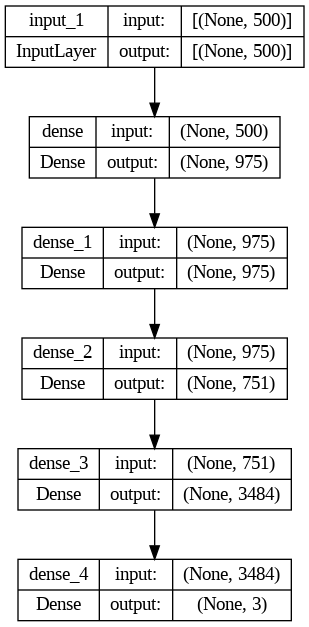

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
save_load_history(history, '/content/drive/MyDrive/maga/history/history_classification_DNN_30epochs', True)

In [ ]:
hist_df = pd.DataFrame(history.history)

In [ ]:
hist_df1 = pd.read_csv('/content/drive/MyDrive/maga/history/classification/3_LSTM_4layers_10callbacs_30epochs', index_col=0)
hist_df2 = pd.read_csv('/content/drive/MyDrive/maga/history/classification/3_LSTM_4layers_10callbacs_10epochs', index_col=0)
hist_df3 = pd.read_csv('/content/drive/MyDrive/maga/history/classification/3_LSTM_4layers_30callbacs_10epochs', index_col=0)
hist_df4 = pd.read_csv('/content/drive/MyDrive/maga/history/classification/3_LSTM_4layers_30callbacs_30epochs', index_col=0)
hist_df5 = pd.read_csv('/content/drive/MyDrive/maga/history/classification/3_LSTM_4layers_30callbacs_50epochs', index_col=0)

Text(0, 0.5, 'Значение метрики accuracy')

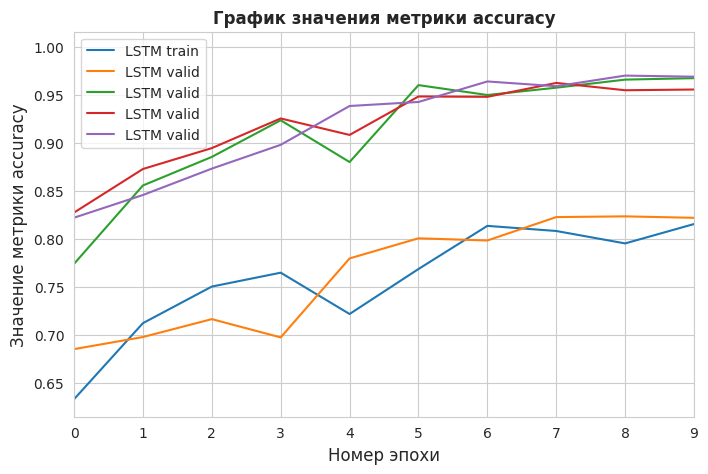

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.lineplot(data=hist_df1['val_acc'], label='LSTM train')
ax = sns.lineplot(data=hist_df2['val_acc'], label='LSTM valid')
ax = sns.lineplot(data=hist_df3['val_acc'], label='LSTM valid')
ax = sns.lineplot(data=hist_df4['val_acc'], label='LSTM valid')
ax = sns.lineplot(data=hist_df5['val_acc'], label='LSTM valid')

ax.set_xlim(0, 9)
ax.set_title('График значения метрики accuracy', fontsize=12, fontweight='bold')
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение метрики accuracy', fontsize=12)
#if plot_name != None:
#  fig.savefig('/content/drive/MyDrive/maga/pic/mae_plot/acc_plot_' + plot_name + '.png')

Text(0, 0.5, 'Значение метрики accuracy')

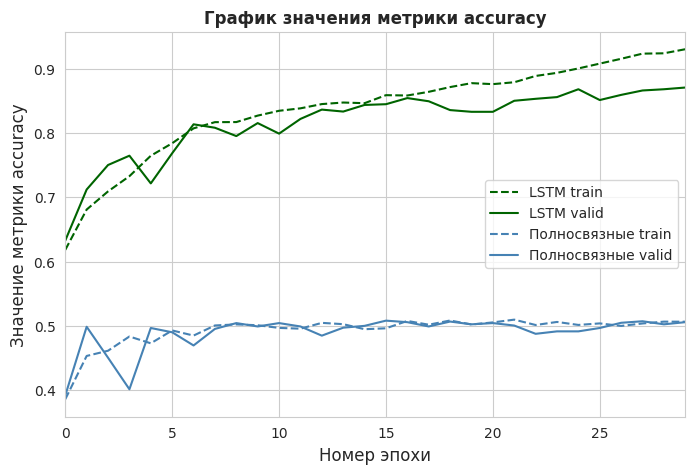

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.lineplot(data=hist_df1['acc'], label='LSTM train', color='darkgreen', linestyle='--')
ax = sns.lineplot(data=hist_df1['val_acc'], label='LSTM valid', color='darkgreen')
ax = sns.lineplot(data=hist_df['acc'], label='Полносвязные train', color='steelblue', linestyle='--')
ax = sns.lineplot(data=hist_df['val_acc'], label='Полносвязные valid', color='steelblue')

ax.set_xlim(0, len(hist_df)-1)
ax.set_title('График значения метрики accuracy', fontsize=12, fontweight='bold')
ax.set_xlabel('Номер эпохи', fontsize=12)
ax.set_ylabel('Значение метрики accuracy', fontsize=12)
#if plot_name != None:
#  fig.savefig('/content/drive/MyDrive/maga/pic/mae_plot/acc_plot_' + plot_name + '.png')

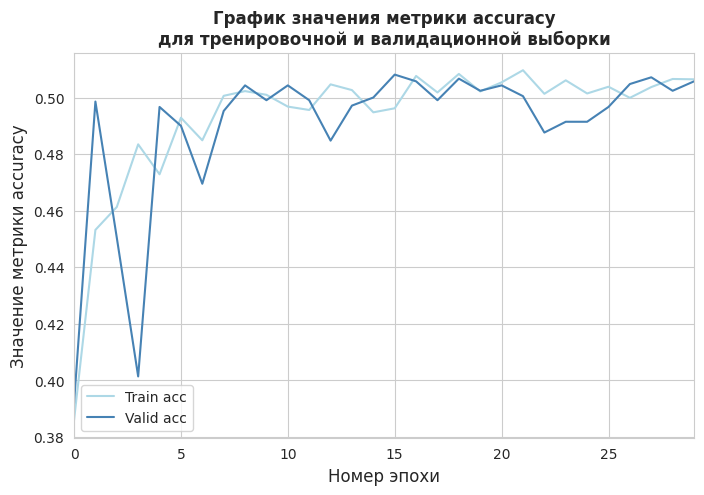

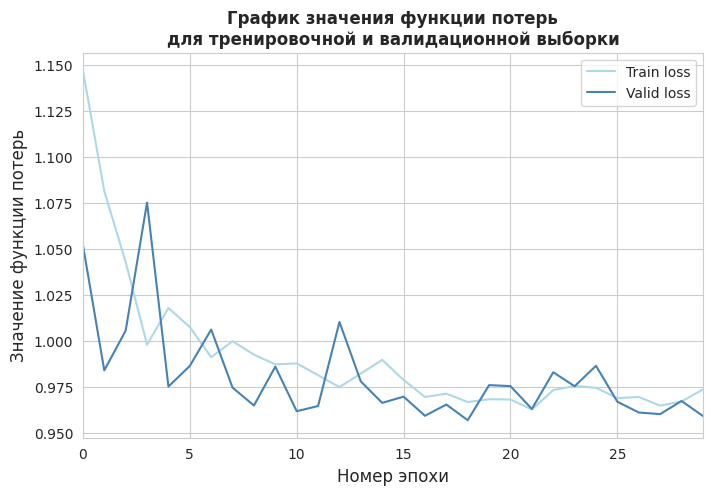

In [ ]:
acc_loss_plot(hist_df, 'history_classification_DNN_30epochs')

In [ ]:
pred_prob = model.predict(X_test)

141/141 [==============================] - 0s 2ms/step


In [ ]:
y_pred_df = pd.DataFrame(pred_prob)
y_pred_df['hot_encod'] = np.argmax(pred_prob, axis=1)

In [ ]:
print_metrics(y_test, y_pred_df['hot_encod'], X_train, 'classification_DNN_50epochs')

{'accuracy': 0.5051111111111111, 'precision': 0.5037252813610895, 'recall': 0.5049548396338667, 'f1': 0.48472220164183843}


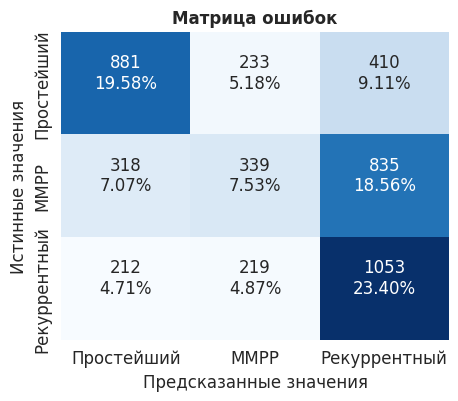

In [ ]:
confusion_matrix_plot(y_test, y_pred_df['hot_encod'], 'classification_DNN_50epochs')

# NN keras LSTM

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/maga/checkpoints/classification_LSTM_4layers_10callbacs')

In [ ]:
checkpoint_name = '/classification_LSTM_4layers_30callbacs_50epochs'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir + checkpoint_name,
                                                 monitor='val_acc',
                                                 save_weights_only=False,
                                                 verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = Sequential([
                    LSTM(256, return_sequences=True, input_shape=(lookback, X.shape[1])),
                    LSTM(256),
                    Dense(32, activation='relu'),
                    Dense(num_class, activation='softmax')
                ])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 256)           775168    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,308,803
Trainable params: 1,308,803
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def myprint(s):
    with open('/content/drive/MyDrive/maga/model_summary/classification/classification3_LSTM_4layers_30callbacs_30epochs.txt','a') as f:
        print(s, file=f)

model.summary(print_fn=myprint)

In [ ]:
history = model.fit(X_train, batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, shuffle=True, epochs=50, callbacks=[cp_callback])

Epoch 1/50
122/123 [============================>.] - ETA: 0s - loss: 0.5705 - acc: 0.7449
Epoch 1: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 23s 115ms/step - loss: 0.5702 - acc: 0.7455 - val_loss: 0.4130 - val_acc: 0.8218
Epoch 2/50
120/123 [============================>.] - ETA: 0s - loss: 0.4372 - acc: 0.8204
Epoch 2: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 80ms/step - loss: 0.4339 - acc: 0.8220 - val_loss: 0.4033 - val_acc: 0.8454
Epoch 3/50
119/123 [============================>.] - ETA: 0s - loss: 0.3889 - acc: 0.8377
Epoch 3: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 76ms/step - loss: 0.3898 - acc: 0.8375 - val_loss: 0.3334 - val_acc: 0.8729
Epoch 4/50
122/123 [============================>.] - ETA: 0s - loss: 0.2883 - acc: 0.8841
Epoch 4: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 79ms/step - loss: 0.2882 - acc: 0.8843 - val_loss: 0.2730 - val_acc: 0.8977
Epoch 5/50
122/123 [============================>.] - ETA: 0s - loss: 0.2438 - acc: 0.9089
Epoch 5: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 76ms/step - loss: 0.2445 - acc: 0.9088 - val_loss: 0.2054 - val_acc: 0.9382
Epoch 6/50
122/123 [============================>.] - ETA: 0s - loss: 0.1869 - acc: 0.9355
Epoch 6: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 83ms/step - loss: 0.1874 - acc: 0.9356 - val_loss: 0.1707 - val_acc: 0.9424
Epoch 7/50
122/123 [============================>.] - ETA: 0s - loss: 0.1567 - acc: 0.9481
Epoch 7: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 8s 69ms/step - loss: 0.1571 - acc: 0.9480 - val_loss: 0.1212 - val_acc: 0.9637
Epoch 8/50
123/123 [==============================] - ETA: 0s - loss: 0.1244 - acc: 0.9585
Epoch 8: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 79ms/step - loss: 0.1244 - acc: 0.9585 - val_loss: 0.1244 - val_acc: 0.9588
Epoch 9/50
120/123 [============================>.] - ETA: 0s - loss: 0.1036 - acc: 0.9637
Epoch 9: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 79ms/step - loss: 0.1036 - acc: 0.9635 - val_loss: 0.0868 - val_acc: 0.9698
Epoch 10/50
122/123 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9652
Epoch 10: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 81ms/step - loss: 0.0899 - acc: 0.9651 - val_loss: 0.0940 - val_acc: 0.9687
Epoch 11/50
120/123 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9736
Epoch 11: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 71ms/step - loss: 0.0721 - acc: 0.9737 - val_loss: 0.1038 - val_acc: 0.9630
Epoch 12/50
123/123 [==============================] - ETA: 0s - loss: 0.0579 - acc: 0.9784
Epoch 12: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 83ms/step - loss: 0.0579 - acc: 0.9784 - val_loss: 0.0875 - val_acc: 0.9718
Epoch 13/50
122/123 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9786
Epoch 13: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 81ms/step - loss: 0.0590 - acc: 0.9786 - val_loss: 0.0589 - val_acc: 0.9809
Epoch 14/50
122/123 [============================>.] - ETA: 0s - loss: 0.0546 - acc: 0.9805
Epoch 14: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 79ms/step - loss: 0.0544 - acc: 0.9807 - val_loss: 0.0547 - val_acc: 0.9798
Epoch 15/50
123/123 [==============================] - ETA: 0s - loss: 0.0376 - acc: 0.9860
Epoch 15: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 77ms/step - loss: 0.0376 - acc: 0.9860 - val_loss: 0.0582 - val_acc: 0.9794
Epoch 16/50
123/123 [==============================] - ETA: 0s - loss: 0.0350 - acc: 0.9866
Epoch 16: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 76ms/step - loss: 0.0350 - acc: 0.9866 - val_loss: 0.0453 - val_acc: 0.9851
Epoch 17/50
121/123 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9857
Epoch 17: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 81ms/step - loss: 0.0400 - acc: 0.9854 - val_loss: 0.0734 - val_acc: 0.9744
Epoch 18/50
121/123 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9826
Epoch 18: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 81ms/step - loss: 0.0462 - acc: 0.9827 - val_loss: 0.0495 - val_acc: 0.9832
Epoch 19/50
121/123 [============================>.] - ETA: 0s - loss: 0.0311 - acc: 0.9897
Epoch 19: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 75ms/step - loss: 0.0315 - acc: 0.9894 - val_loss: 0.0598 - val_acc: 0.9779
Epoch 20/50
119/123 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9894
Epoch 20: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 75ms/step - loss: 0.0307 - acc: 0.9894 - val_loss: 0.0784 - val_acc: 0.9691
Epoch 21/50
120/123 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9913
Epoch 21: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 81ms/step - loss: 0.0261 - acc: 0.9912 - val_loss: 0.0354 - val_acc: 0.9878
Epoch 22/50
122/123 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9863
Epoch 22: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 82ms/step - loss: 0.0408 - acc: 0.9863 - val_loss: 0.0510 - val_acc: 0.9813
Epoch 23/50
123/123 [==============================] - ETA: 0s - loss: 0.0225 - acc: 0.9931
Epoch 23: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 70ms/step - loss: 0.0225 - acc: 0.9931 - val_loss: 0.0248 - val_acc: 0.9920
Epoch 24/50
122/123 [============================>.] - ETA: 0s - loss: 0.0193 - acc: 0.9935
Epoch 24: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 82ms/step - loss: 0.0192 - acc: 0.9935 - val_loss: 0.0560 - val_acc: 0.9798
Epoch 25/50
120/123 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9896
Epoch 25: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 82ms/step - loss: 0.0283 - acc: 0.9896 - val_loss: 0.0290 - val_acc: 0.9916
Epoch 26/50
123/123 [==============================] - ETA: 0s - loss: 0.0173 - acc: 0.9949
Epoch 26: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 79ms/step - loss: 0.0173 - acc: 0.9949 - val_loss: 0.0206 - val_acc: 0.9931
Epoch 27/50
119/123 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9929
Epoch 27: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 77ms/step - loss: 0.0216 - acc: 0.9930 - val_loss: 0.0455 - val_acc: 0.9840
Epoch 28/50
120/123 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9954
Epoch 28: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 75ms/step - loss: 0.0139 - acc: 0.9953 - val_loss: 0.0235 - val_acc: 0.9920
Epoch 29/50
122/123 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9937
Epoch 29: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 82ms/step - loss: 0.0164 - acc: 0.9938 - val_loss: 0.0253 - val_acc: 0.9893
Epoch 30/50
123/123 [==============================] - ETA: 0s - loss: 0.0188 - acc: 0.9943
Epoch 30: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 82ms/step - loss: 0.0188 - acc: 0.9943 - val_loss: 0.0411 - val_acc: 0.9866
Epoch 31/50
119/123 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9970
Epoch 31: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 76ms/step - loss: 0.0084 - acc: 0.9971 - val_loss: 0.0130 - val_acc: 0.9969
Epoch 32/50
123/123 [==============================] - ETA: 0s - loss: 0.0096 - acc: 0.9962
Epoch 32: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 76ms/step - loss: 0.0096 - acc: 0.9962 - val_loss: 0.0381 - val_acc: 0.9866
Epoch 33/50
119/123 [============================>.] - ETA: 0s - loss: 0.0116 - acc: 0.9957
Epoch 33: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 83ms/step - loss: 0.0114 - acc: 0.9958 - val_loss: 0.0181 - val_acc: 0.9935
Epoch 34/50
120/123 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9935
Epoch 34: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 83ms/step - loss: 0.0203 - acc: 0.9929 - val_loss: 0.0449 - val_acc: 0.9847
Epoch 35/50
120/123 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9918
Epoch 35: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 72ms/step - loss: 0.0218 - acc: 0.9920 - val_loss: 0.0406 - val_acc: 0.9878
Epoch 36/50
119/123 [============================>.] - ETA: 0s - loss: 0.0116 - acc: 0.9962
Epoch 36: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 81ms/step - loss: 0.0113 - acc: 0.9963 - val_loss: 0.0154 - val_acc: 0.9958
Epoch 37/50
121/123 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.9996
Epoch 37: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 77ms/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0137 - val_acc: 0.9950
Epoch 38/50
119/123 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9967
Epoch 38: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 83ms/step - loss: 0.0104 - acc: 0.9968 - val_loss: 0.0142 - val_acc: 0.9958
Epoch 39/50
121/123 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.9996
Epoch 39: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 75ms/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0243 - val_acc: 0.9931
Epoch 40/50
122/123 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9992
Epoch 40: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 78ms/step - loss: 0.0025 - acc: 0.9992 - val_loss: 0.0099 - val_acc: 0.9973
Epoch 41/50
121/123 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9975
Epoch 41: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 77ms/step - loss: 0.0080 - acc: 0.9976 - val_loss: 0.0233 - val_acc: 0.9920
Epoch 42/50
122/123 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9932
Epoch 42: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 83ms/step - loss: 0.0213 - acc: 0.9933 - val_loss: 0.0301 - val_acc: 0.9912
Epoch 43/50
121/123 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9944
Epoch 43: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 75ms/step - loss: 0.0158 - acc: 0.9945 - val_loss: 0.0325 - val_acc: 0.9901
Epoch 44/50
122/123 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9965
Epoch 44: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 74ms/step - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0273 - val_acc: 0.9912
Epoch 45/50
119/123 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9954
Epoch 45: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 82ms/step - loss: 0.0138 - acc: 0.9954 - val_loss: 0.0265 - val_acc: 0.9908
Epoch 46/50
121/123 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9990
Epoch 46: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 80ms/step - loss: 0.0037 - acc: 0.9990 - val_loss: 0.0101 - val_acc: 0.9962
Epoch 47/50
119/123 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9989
Epoch 47: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 70ms/step - loss: 0.0029 - acc: 0.9989 - val_loss: 0.0978 - val_acc: 0.9737
Epoch 48/50
121/123 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9961
Epoch 48: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 81ms/step - loss: 0.0104 - acc: 0.9962 - val_loss: 0.0131 - val_acc: 0.9954
Epoch 49/50
119/123 [============================>.] - ETA: 0s - loss: 2.8864e-04 - acc: 1.0000
Epoch 49: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 9s 77ms/step - loss: 2.8455e-04 - acc: 1.0000 - val_loss: 0.0103 - val_acc: 0.9969
Epoch 50/50
121/123 [============================>.] - ETA: 0s - loss: 1.1269e-04 - acc: 1.0000
Epoch 50: saving model to /content/drive/MyDrive/maga/checkpoints/classification/3/classification_LSTM_4layers_30callbacs_50epochs


123/123 [==============================] - 10s 82ms/step - loss: 1.1304e-04 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9969


In [ ]:
save_load_history(history, '/content/drive/MyDrive/maga/history/classification/3_LSTM_4layers_30callbacs_50epochs', True)

In [ ]:
hist_df = pd.DataFrame(history.history)

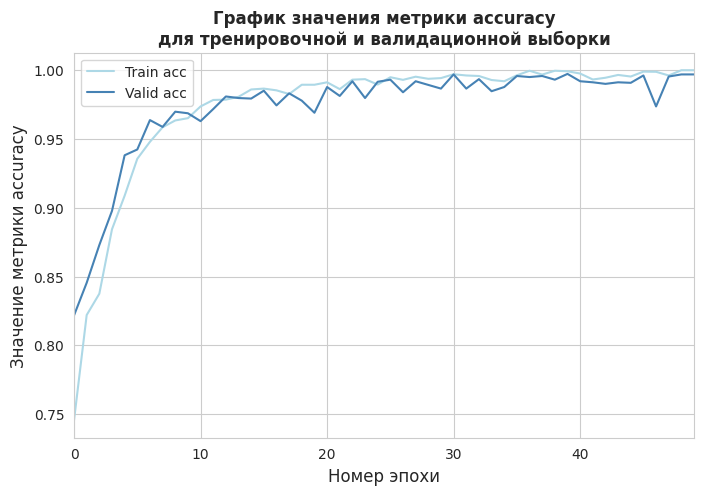

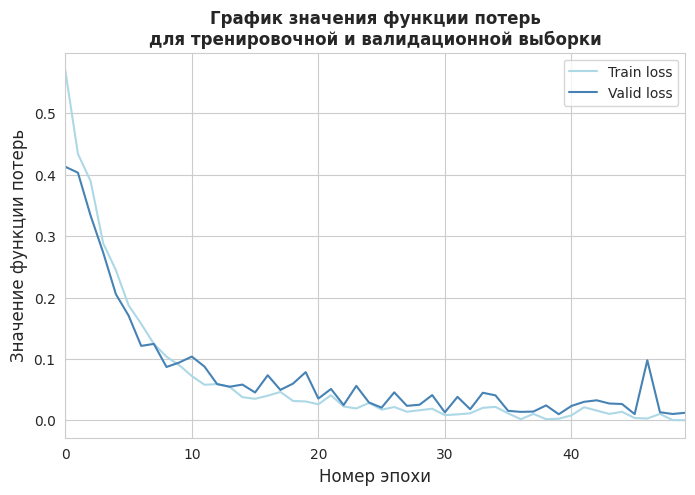

In [ ]:
acc_loss_plot(hist_df, 'classification_3_LSTM_4layers_30callbacs_50epochs')

In [ ]:
pred_prob = model.predict(X_test)

141/141 [==============================] - 1s 5ms/step


In [ ]:
y_pred_df = pd.DataFrame(pred_prob)
y_pred_df['hot_encod'] = np.argmax(pred_prob, axis=1)

In [ ]:
print_metrics(y_test, y_pred_df['hot_encod'], X_train, 'classification_3_LSTM_4layers_30callbacs_50epochs')

{'accuracy': 0.9953239812959251, 'precision': 0.9953052170131299, 'recall': 0.9953280303362543, 'f1': 0.9953098115993493}


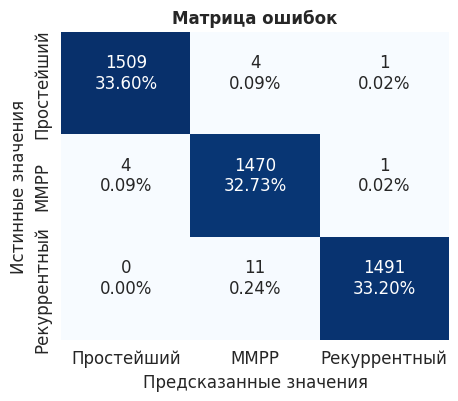

In [ ]:
confusion_matrix_plot(y_test, y_pred_df['hot_encod'], 'classification_3_LSTM_4layers_30callbacs_50epochs')

# Compare

In [22]:
model1 = keras.models.load_model('/content/drive/MyDrive/maga/checkpoints/classification_LSTM_4layers_10callbacs_10epochs')
model2 = keras.models.load_model('/content/drive/MyDrive/maga/checkpoints/classification_LSTM_4layers_10callbacs_30epochs')
model3 = keras.models.load_model('/content/drive/MyDrive/maga/checkpoints/classification_LSTM_4layers_30callbacs_10epochs')
model4 = keras.models.load_model('/content/drive/MyDrive/maga/checkpoints/classification_LSTM_4layers_30callbacs_30epochs')
model5 = keras.models.load_model('/content/drive/MyDrive/maga/checkpoints/classification_LSTM_4layers_30callbacs_50epochs')

In [83]:
pred_prob1 = model1.predict(X_test)
pred_prob2 = model2.predict(X_test)

141/141 [==============================] - 1s 3ms/step


In [26]:
pred_prob3 = model3.predict(X_test)
pred_prob4 = model4.predict(X_test)
pred_prob5 = model5.predict(X_test)

141/141 [==============================] - 2s 8ms/step


In [27]:
from itertools import cycle
from sklearn.preprocessing import label_binarize

In [96]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

In [97]:
roc_auc1 = dict()
roc_auc2 = dict()
roc_auc3 = dict()
roc_auc4 = dict()
roc_auc5 = dict()

In [98]:
fpr = dict()
tpr = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_prob5[:, i])
    roc_auc5[i] = auc(fpr[i], tpr[i])

In [53]:
# d = {'model': ['10c_10e', '10c_30e', '30c_10e', '30c_30e', '30c_50e'],
#      'pois': [roc_auc1[0], roc_auc2[0], roc_auc3[0], roc_auc4[0], roc_auc5[0]],
#      'mmpp': [roc_auc1[1], roc_auc2[1], roc_auc3[1], roc_auc4[1], roc_auc5[1]],
#      'recurr': [roc_auc1[2], roc_auc2[2], roc_auc3[2], roc_auc4[2], roc_auc5[2]]
#      }
# aucroc_df = pd.DataFrame(data=d)

In [54]:
# with open('/content/drive/MyDrive/maga/metrics/classification/3_aucroc_metrics.csv', mode='w') as f:
#   aucroc_df.to_csv(f)

In [101]:
roc_auc5

{0: 0.9999889065841198, 1: 0.999939981117655, 2: 0.9999766119802792}

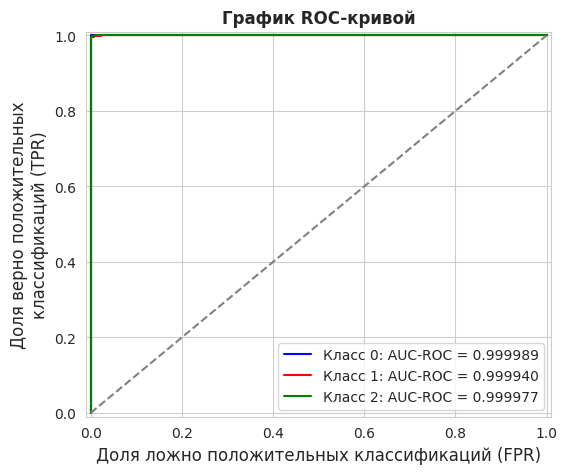

In [100]:
sns.set_style("whitegrid")
plt.subplots(figsize=(6, 5))

colors = cycle(['blue', 'red', 'green'])

# Plot of a ROC curve for a specific class
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='Класс {0}: AUC-ROC = {1:0.6f}'''.format(i, roc_auc5[i]))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Доля ложно положительных классификаций (FPR)', fontsize = 12)
plt.ylabel('Доля верно положительных\nклассификаций (TPR)', fontsize = 12)
plt.title('График ROC-кривой', fontsize = 12, fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/maga/pic/classification_3_AUCROC_30callbacs_50epochs.png', bbox_inches="tight")